In [3]:
#!/bin/python
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
import matplotlib.pyplot as plt

import ctcfgen
import sequence
import eval_TFmodel
import train_TFmodel
import numpy as np
import viz_sequence
import seq_only_gen


# get the generator
gen = seq_only_gen.TFGenerator('/home/kal/TF_models/seq_only/ctcfgen.hdf5')
g = gen.pos_gen()

In [9]:
seq = sequence.Sequence(next(g)[0])
sigmodel = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/20170919_sigmoid_model/')
regmodel = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_regression/20170920_regression_model/')
regmodel = reg = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_regression/20180125_174348_CTCF/')
regmodel.model.predict(train_TFmodel.blank_batch(seq.seq))[0][0]

568.7168

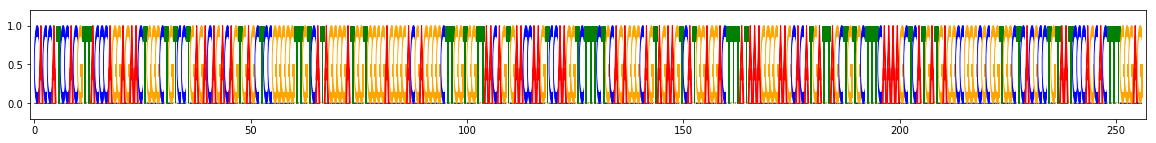

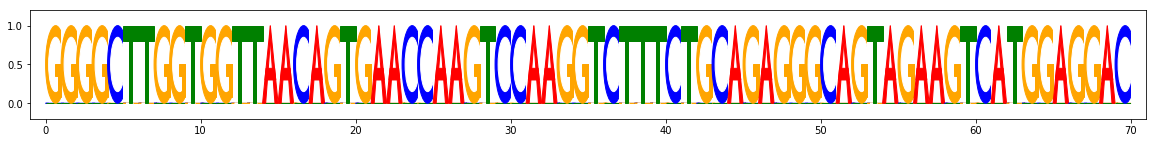

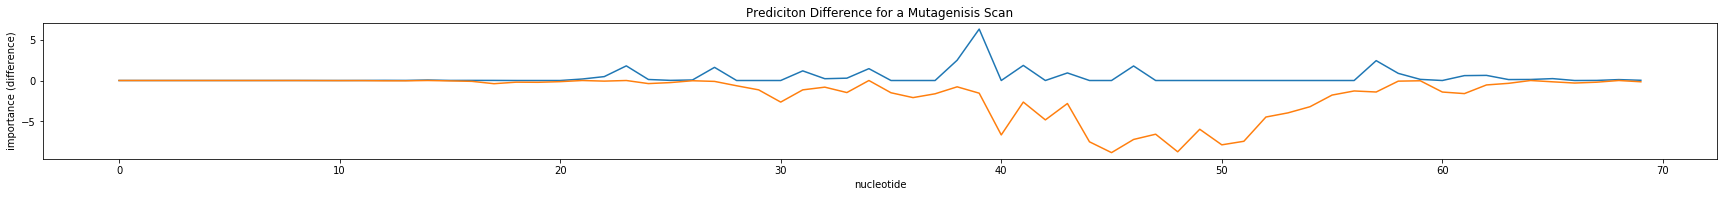

Masked average prediciton difference


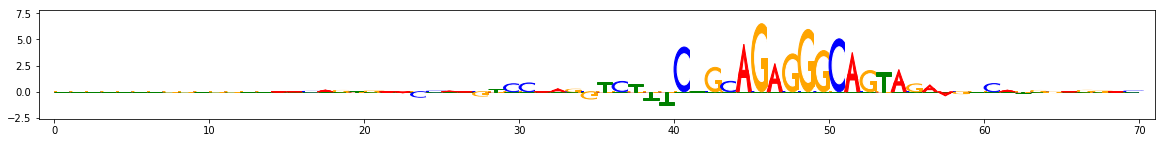

Information Content of Softmax prediction difference


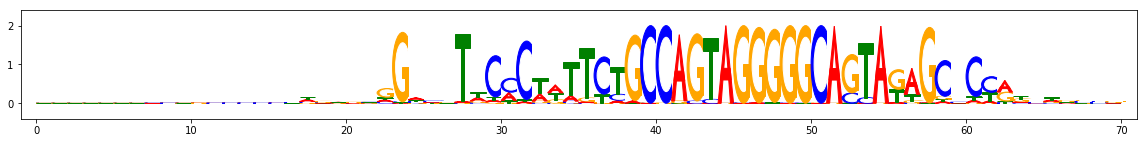

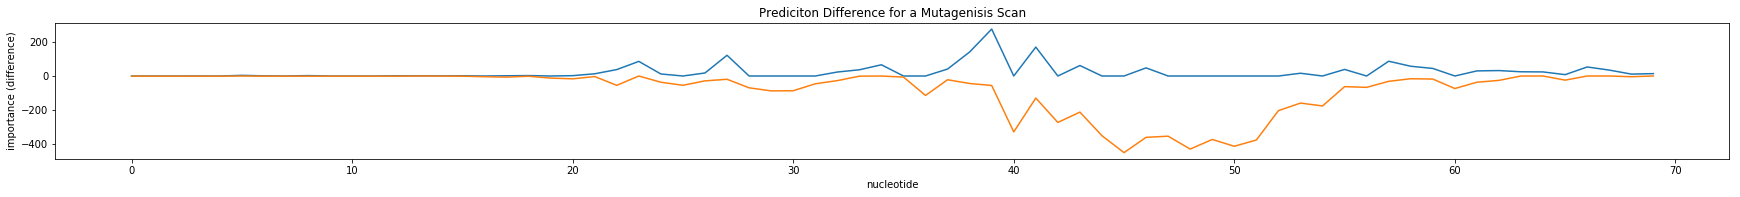

Masked average prediciton difference


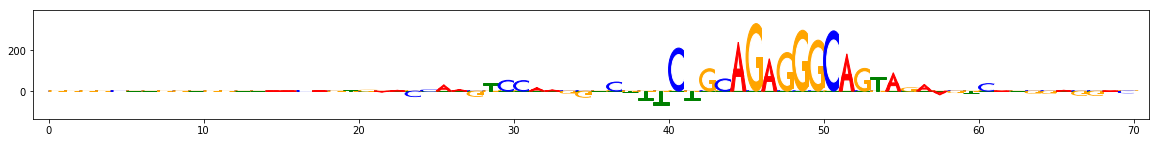

Information Content of Softmax prediction difference


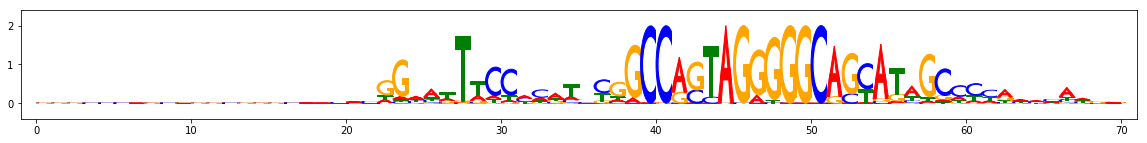

In [10]:
#print some stuff
seq.logo()
viz_sequence.plot_weights(seq.seq[90:160])
sigmodel.get_importance(seq, viz=True, plot=True, start=90, end=160)
importance = regmodel.get_importance(seq, viz=True, plot=True, start=90, end=160)

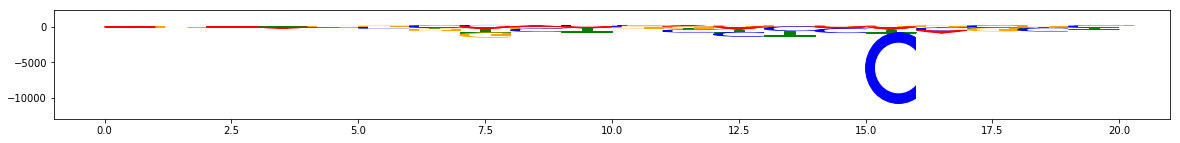

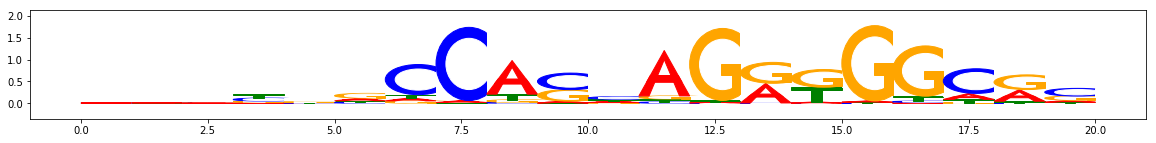

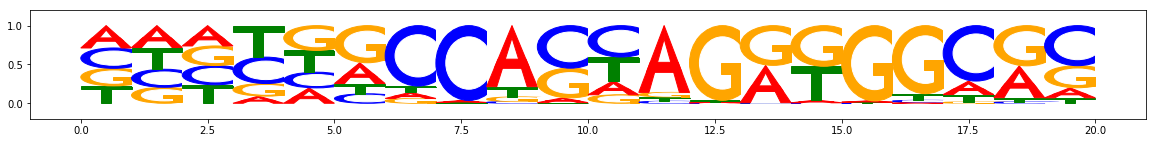

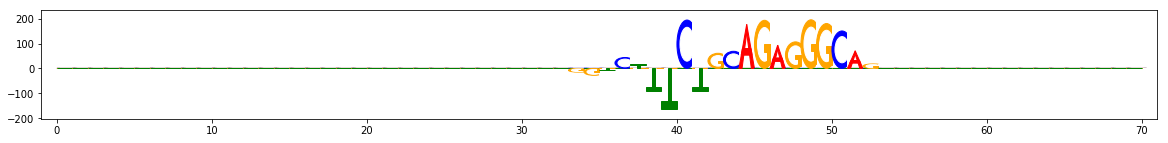

In [11]:
# print more stuff
meme, position, score = seq.find_pwm()
overlap = seq.run_pwm(meme=meme, position=position)
viz_sequence.plot_weights(meme.pwm)
viz_sequence.plot_icweights(meme.seq)
viz_sequence.plot_weights(meme.seq)
viz_sequence.plot_weights(overlap[90:160])